In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
44782,NaN,NaN,International,2020-09-17,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44783,NaN,NaN,International,2020-09-18,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44784,NaN,NaN,International,2020-09-19,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


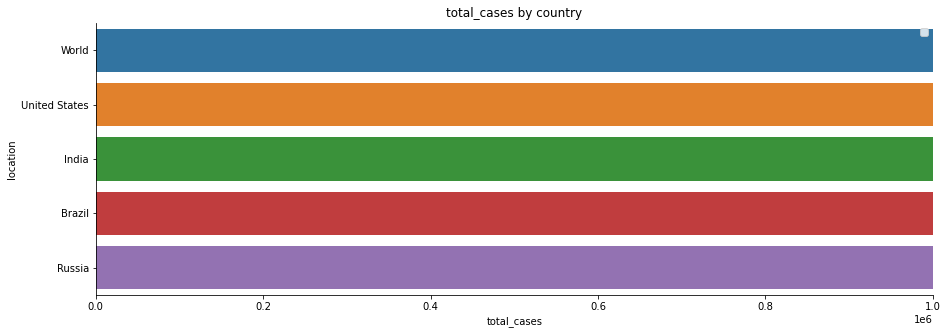

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


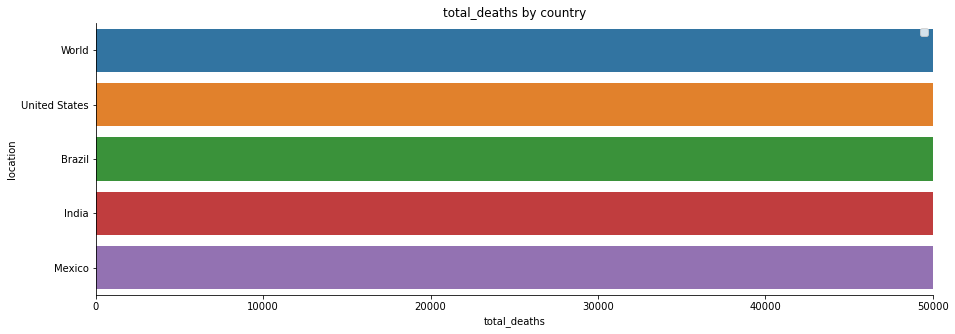

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


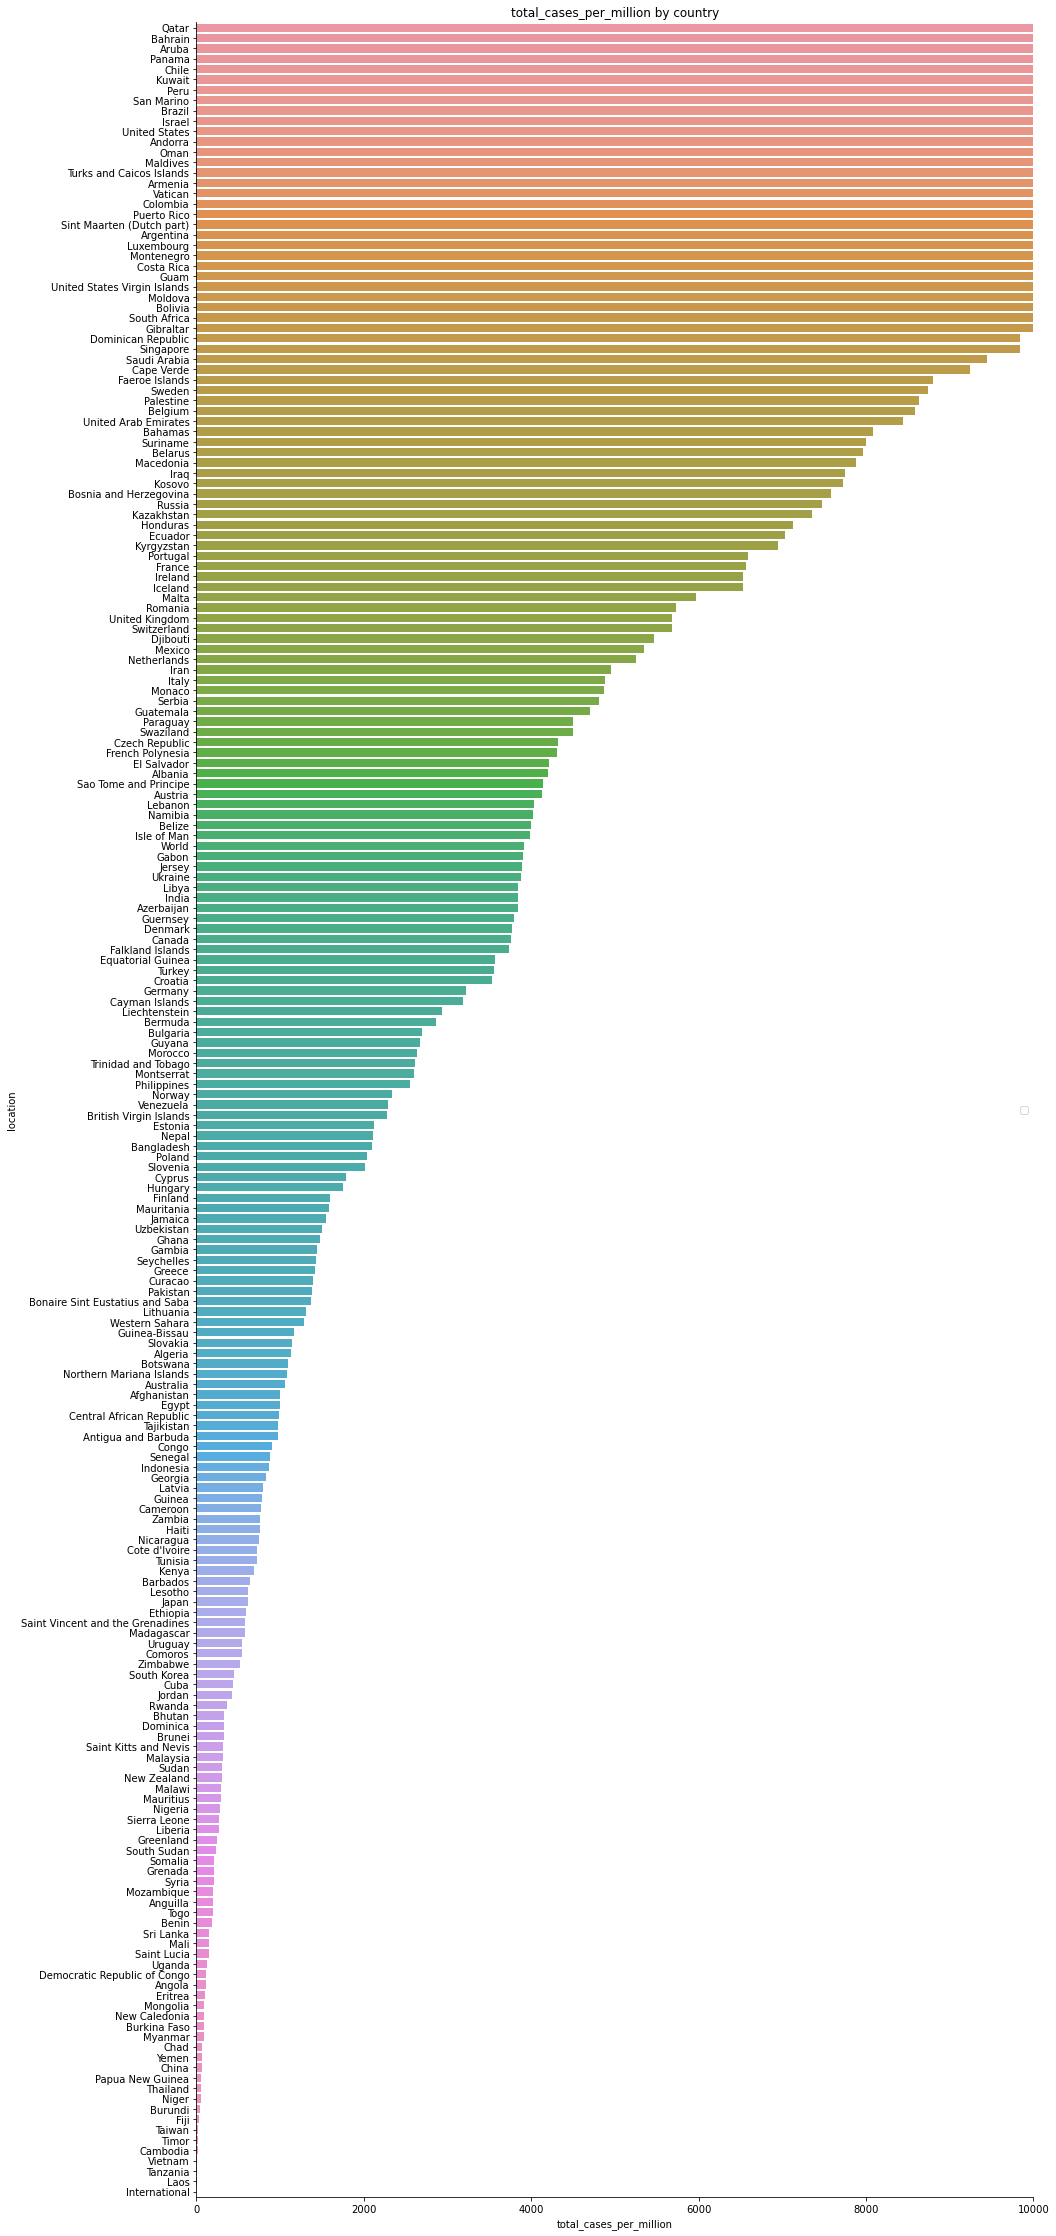

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


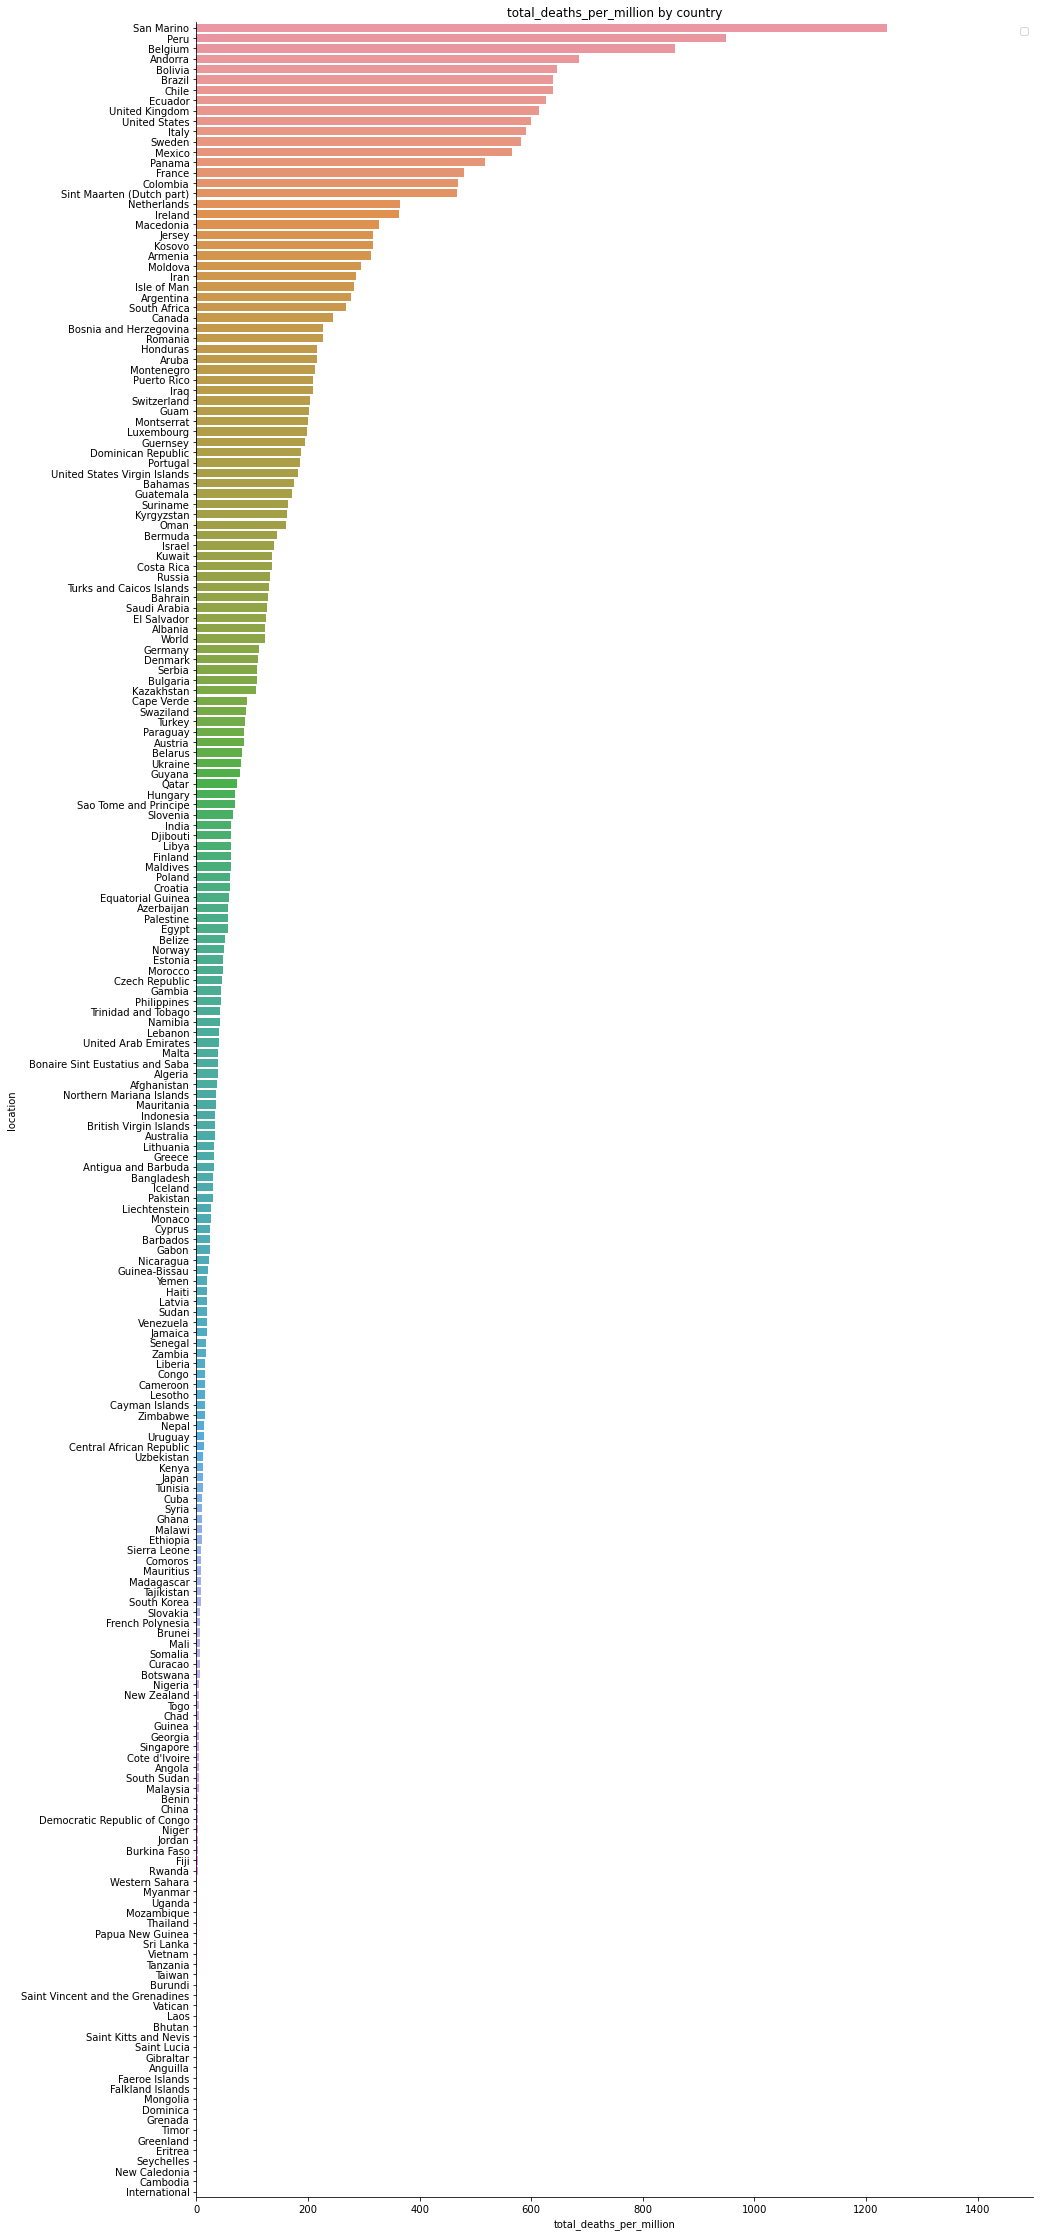

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

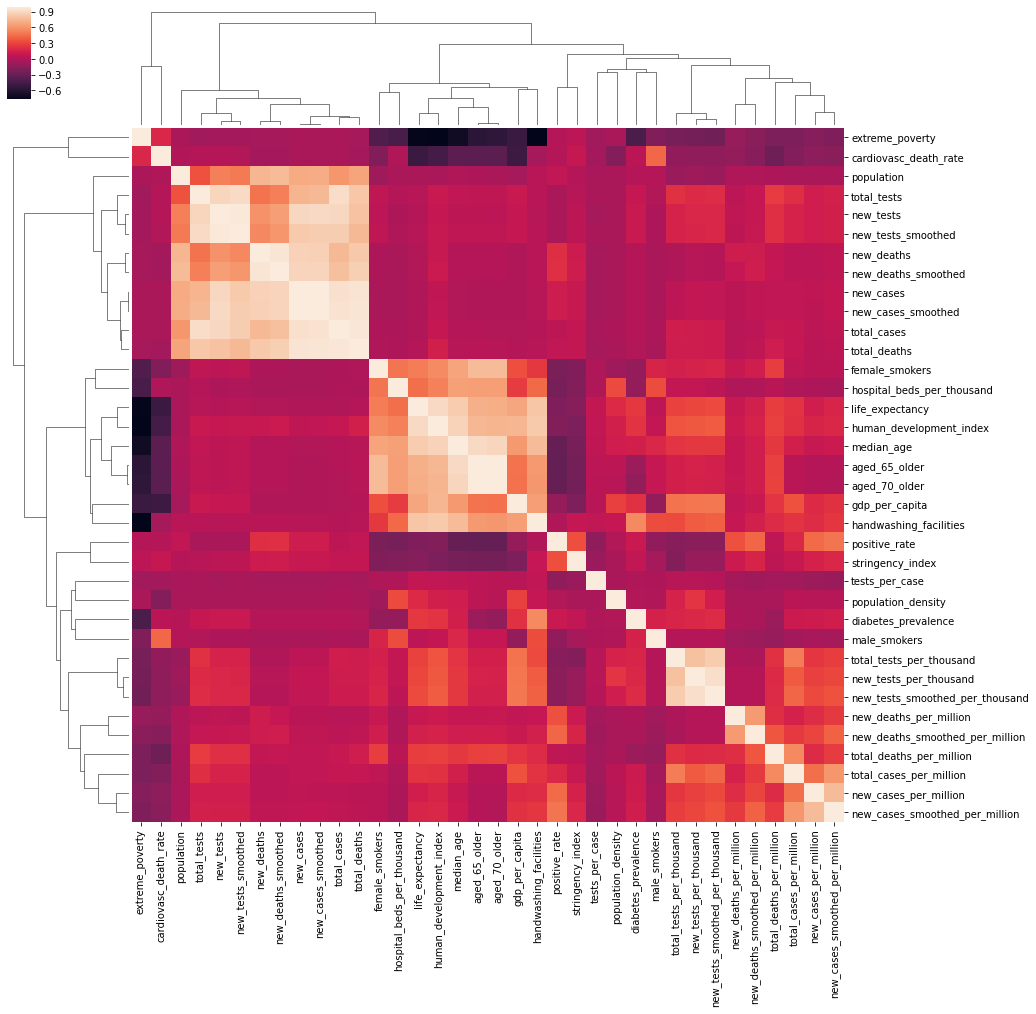

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9987686353499399 (+/- 0.0015447559797416633)
Coef :  [1.03231234e+00 8.54404450e-05 8.76516568e-05]
3 Last_days :  [[29917712 30231370 30540446]]
Today :  30540446
Prediction + :  450230
Tomorow :  30990676
                                     
--------- Total Death -----------------
                                     
R^2: 0.999683810547752 (+/- 0.00012070850885865273)
Coef :  [0.19843864 0.39425792 0.41747601]
3 Last_days :  [[941460 946777 952724]]
Today :  952724
Prediction + :  8319
Tomorow :  961043
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.5393381531607333 (+/- 0.6475618379611516)
Coef :  [-0.76871943  0.79570233  0.97781986]
3 Last_days :  [[404888 415481 428696]]
Today :  428696
Prediction + :  9771
Tomorow :  438467
                                     
--------- Total Death -----------------
                                     
R^2: 0.9870852167561974 (+/- 0.00833121685694115)
Coef :  [-0.74737899  0.78825676  0.95812035]
3 Last_days :  [[31045 31095 31249]]
Today :  31249
Prediction + :  53
Tomorow :  31302
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9567598090813473 (+/- 0.03966172325863374)
Coef :  [-0.32924015 -0.0116048   1.33511043]
3 Last_days :  [[90250 90294 90308]]
Today :  90308
Prediction + :  29
Tomorow :  90337
                                     
--------- Total Death -----------------
                                     
R^2: -65.52313006832743 (+/- 93.97690785294489)
Coef :  [-0.07752977  0.01247369  1.05679386]
3 Last_days :  [[4736 4736 4737]]
Today :  4737
Prediction + :  5
Tomorow :  4742
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9443790461766598 (+/- 0.07769436848305775)
Coef :  [-0.81385038  0.89335368  0.91992956]
3 Last_days :  [[291442 293025 294932]]
Today :  294932
Prediction + :  1367
Tomorow :  296299
                                     
--------- Total Death -----------------
                                     
R^2: 0.9397823861292514 (+/- 0.06385147355925133)
Coef :  [-0.82119392  0.89600395  0.92420505]
3 Last_days :  [[35645 35658 35668]]
Today :  35668
Prediction + :  30
Tomorow :  35698
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.5864478511912089 (+/- 0.5764139534226334)
Coef :  [-0.32973955  0.18803274  1.14843386]
3 Last_days :  [[614360 625651 640040]]
Today :  640040
Prediction + :  10137
Tomorow :  650177
                                     
--------- Total Death -----------------
                                     
R^2: -0.08145410220366549 (+/- 1.230852249537616)
Coef :  [-0.73009862  0.64088172  1.08826994]
3 Last_days :  [[30243 30405 30495]]
Today :  30495
Prediction + :  135
Tomorow :  30630
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9649750984640878 (+/- 0.04813925706773733)
Coef :  [0.10403377 0.4513147  0.45734566]
3 Last_days :  [[6630891 6674458 6724667]]
Today :  6724667
Prediction + :  70426
Tomorow :  6795093
                                     
--------- Total Death -----------------
                                     
R^2: 0.9946903632230916 (+/- 0.006223412494250025)
Coef :  [-0.41691055  0.67726803  0.74244859]
3 Last_days :  [[196802 197633 198589]]
Today :  198589
Prediction + :  1083
Tomorow :  199672
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9435307764821618 (+/- 0.07931386533022657)
Coef :  [-0.67734935  0.82725267  0.85092425]
3 Last_days :  [[378219 381614 385936]]
Today :  385936
Prediction + :  2549
Tomorow :  388485
                                     
--------- Total Death -----------------
                                     
R^2: 0.2672137598191332 (+/- 0.9935696885551187)
Coef :  [-0.765188    0.83023983  0.93421662]
3 Last_days :  [[41684 41705 41732]]
Today :  41732
Prediction + :  48
Tomorow :  41780
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.31098284984568036 (+/- 0.9735175555917687)
Coef :  [-0.78017397  0.85025331  0.92987571]
3 Last_days :  [[265857 267773 270070]]
Today :  270070
Prediction + :  1639
Tomorow :  271709
                                     
--------- Total Death -----------------
                                     
R^2: 0.27656936823631445 (+/- 1.0144980608328857)
Coef :  [-0.7847645   0.83926591  0.94471616]
3 Last_days :  [[9371 9378 9384]]
Today :  9384
Prediction + :  11
Tomorow :  9395
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9557996283172562 (+/- 0.06062603838425407)
Coef :  [0.32216221 0.34607768 0.34252298]
3 Last_days :  [[410334 413149 416198]]
Today :  416198
Prediction + :  3133
Tomorow :  419331
                                     
--------- Total Death -----------------
                                     
R^2: 0.9655998643794322 (+/- 0.0480153702634982)
Coef :  [0.11856131 0.45195749 0.4403565 ]
3 Last_days :  [[23632 23808 23952]]
Today :  23952
Prediction + :  225
Tomorow :  24177
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.999508069500704 (+/- 0.00043265056420049993)
Coef :  [-0.64866906  0.8085317   0.83755763]
3 Last_days :  [[296391 298039 299810]]
Today :  299810
Prediction + :  1275
Tomorow :  301085
                                     
--------- Total Death -----------------
                                     
R^2: 0.9990669993601187 (+/- 0.0008490190820156104)
Coef :  [-0.81455193  0.89423548  0.91839363]
3 Last_days :  [[7249 7315 7377]]
Today :  7377
Prediction + :  53
Tomorow :  7430
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9915216282766819 (+/- 0.009406527125467017)
Coef :  [-0.13706003  0.51658269  0.63311022]
3 Last_days :  [[4419083 4455386 4495183]]
Today :  4495183
Prediction + :  54761
Tomorow :  4549944
                                     
--------- Total Death -----------------
                                     
R^2: 0.46757528705295853 (+/- 0.7499711104043091)
Coef :  [-0.04453429  0.49233775  0.56286752]
3 Last_days :  [[134106 134935 135793]]
Today :  135793
Prediction + :  1428
Tomorow :  137221
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(30540446, 952724, 30990676, 961043),
 (428696, 31249, 438467, 31302),
 (294932, 35668, 296299, 35698),
 (640040, 30495, 650177, 30630),
 (6724667, 198589, 6795093, 199672),
 (90308, 4737, 90337, 4742),
 (385936, 41732, 388485, 41780),
 (270070, 9384, 271709, 9395),
 (416198, 23952, 419331, 24177),
 (299810, 7377, 301085, 7430),
 (4495183, 135793, 4549944, 137221)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-19,France,438467.0,0.0,31302.0,0.0,0.0,0.0
0,2020-09-19,China,90337.0,0.0,4742.0,0.0,0.0,0.0
0,2020-09-19,Italy,296299.0,0.0,35698.0,0.0,0.0,0.0
0,2020-09-19,Spain,650177.0,0.0,30630.0,0.0,0.0,0.0
0,2020-09-19,United States,6795093.0,0.0,199672.0,0.0,0.0,0.0
0,2020-09-19,World,30990676.0,0.0,961043.0,0.0,0.0,0.0
0,2020-09-19,United Kingdom,388485.0,0.0,41780.0,0.0,0.0,0.0
0,2020-09-19,Germany,271709.0,0.0,9395.0,0.0,0.0,0.0
0,2020-09-19,Iran,419331.0,0.0,24177.0,0.0,0.0,0.0
0,2020-09-19,Turkey,301085.0,0.0,7430.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")